In [ ]:
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np
from typing import Dict, List, Any

def extract_comprehensive_uncertainty_features(output, tokenizer) -> Dict[str, float]:
    """
    Extract richer uncertainty and confidence features from model output.
    Includes residual mass, top-1 vs top-2 margin, variance, and extreme values.
    """
    features = {}
    
    if not hasattr(output, 'scores') or not output.scores:
        return {f: 0.0 for f in get_feature_names()}
    
    
    logits_list = [score[0] for score in output.scores]  
    probs_list = [F.softmax(logits, dim=-1) for logits in logits_list]
    
    
    
    
    entropies = [-(probs * torch.log(probs + 1e-8)).sum().item() for probs in probs_list]
    features['mean_entropy'] = float(np.mean(entropies))
    features['max_entropy'] = float(np.max(entropies))
    features['min_entropy'] = float(np.min(entropies))
    features['std_entropy'] = float(np.std(entropies))
    
    
    
    
    max_probs = [torch.max(probs).item() for probs in probs_list]
    features['mean_max_prob'] = float(np.mean(max_probs))
    features['min_max_prob'] = float(np.min(max_probs))
    features['std_max_prob'] = float(np.std(max_probs))
    
    max_possible_entropy = torch.log(torch.tensor(probs_list[0].shape[-1])).item()
    confidences = [1 - (ent / max_possible_entropy) for ent in entropies]
    features['mean_confidence'] = float(np.mean(confidences))
    features['min_confidence'] = float(np.min(confidences))
    
    
    
    
    top2_ratios, margins, residual5, residual10 = [], [], [], []
    
    for probs in probs_list:
        sorted_probs, _ = torch.sort(probs, descending=True)
        
        
        if len(sorted_probs) >= 2:
            top2_ratios.append((sorted_probs[0] / (sorted_probs[1] + 1e-8)).item())
            margins.append((sorted_probs[0] - sorted_probs[1]).item())
        
        
        residual5.append((1.0 - sorted_probs[:5].sum()).item())
        residual10.append((1.0 - sorted_probs[:10].sum()).item())
    
    features['mean_top2_ratio'] = float(np.mean(top2_ratios)) if top2_ratios else 0.0
    features['mean_margin'] = float(np.mean(margins)) if margins else 0.0
    features['residual_top5'] = float(np.mean(residual5))
    features['residual_top10'] = float(np.mean(residual10))
    
    
    
    
    features['sequence_length'] = len(output.scores)
    features['prob_variance'] = float(np.var(max_probs))
    features['entropy_variance'] = float(np.var(entropies))
    features['entropy_range'] = float(np.max(entropies) - np.min(entropies))
    
    
    features['perplexity'] = float(np.exp(features['mean_entropy']))
    
    
    
    
    sharpness_scores = []
    for probs in probs_list:
        sorted_probs = torch.sort(probs, descending=True)[0]
        n = len(sorted_probs)
        index = torch.arange(1, n + 1, dtype=torch.float32, device=probs.device)
        gini = (2 * torch.sum(index * sorted_probs)) / (n * torch.sum(sorted_probs)) - (n + 1) / n
        sharpness_scores.append(gini.item())
    features['mean_sharpness'] = float(np.mean(sharpness_scores))
    
    
    
    
    if hasattr(output, 'sequences'):
        generated_tokens = output.sequences[0]
        generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
        
        features['has_syntax_keywords'] = float(any(keyword in generated_text.lower() 
                                                   for keyword in ['def', 'class', 'if', 'for', 'while', 'return']))
        features['has_parentheses'] = float('(' in generated_text and ')' in generated_text)
        features['has_brackets'] = float('[' in generated_text and ']' in generated_text)
        features['has_braces'] = float('{' in generated_text and '}' in generated_text)
        features['indentation_consistency'] = calculate_indentation_consistency(generated_text)
        
        words = generated_text.split()
        features['word_repetition_ratio'] = 1.0 - (len(set(words)) / len(words)) if words else 0.0
    else:
        features.update({
            'has_syntax_keywords': 0.0,
            'has_parentheses': 0.0,
            'has_brackets': 0.0,
            'has_braces': 0.0,
            'indentation_consistency': 0.0,
            'word_repetition_ratio': 0.0,
        })
    
    
    
    
    features['attention_entropy'] = 0.0
    features['attention_variance'] = 0.0
    
    return features

def calculate_indentation_consistency(text: str) -> float:
    """Calculate consistency of indentation in generated code"""
    lines = text.split('\n')
    indentations = []
    
    for line in lines:
        if line.strip():  
            indent = len(line) - len(line.lstrip())
            indentations.append(indent)
    
    if len(indentations) < 2:
        return 1.0
    
    
    if all(indent % 4 == 0 for indent in indentations):
        return 1.0
    elif all(indent % 2 == 0 for indent in indentations):
        return 0.8
    else:
        return 0.5

def get_feature_names() -> List[str]:
    """Return list of all feature names for consistent ordering"""
    return [
        
        'mean_entropy', 'max_entropy', 'min_entropy', 'std_entropy',
        
        'mean_max_prob', 'min_max_prob', 'std_max_prob',
        'mean_confidence', 'min_confidence',
        
        'mean_top2_ratio', 'mean_top5_sum', 'mean_top10_sum',
        
        'sequence_length', 'perplexity', 'prob_variance', 'mean_sharpness',
        
        'has_syntax_keywords', 'has_parentheses', 'has_brackets', 'has_braces',
        'indentation_consistency', 'word_repetition_ratio',
        
        'attention_entropy', 'attention_variance'
    ]





def process_dataset_with_enhanced_features(csv_path, model, tokenizer, save_path="enhanced_router_dataset.csv", batch_size=3):
    """
    Updated version of your processing function with comprehensive feature extraction
    """
    print("Loading dataset...")
    df = pd.read_csv(csv_path)
    print(f"Loaded {len(df)} problems")
    
    results = []
    total_batches = (len(df) + batch_size - 1) // batch_size
    
    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(df))
        batch_df = df.iloc[start_idx:end_idx]
        
        print(f"\n--- Processing Batch {batch_idx + 1}/{total_batches} (Problems {start_idx+1}-{end_idx}) ---")
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            
        for idx, row in batch_df.iterrows():
            print(f"\nProcessing {idx+1}/{len(df)}: {row['seq_id']}")
            
            try:
                
                messages = [
                    {
                        "role": "system",
                        "content": "You are a skilled Python programmer. Write clean, working code without comments or explanations. Focus only on solving the problem correctly."
                    },
                    {
                        "role": "user", 
                        "content": f"Write a Python function to solve this problem. Provide only the function code without comments or explanations:\n\n{row['instruction']}"
                    }
                ]
                
                prompt = tokenizer.apply_chat_template(
                    messages,
                    tokenize=False,
                    add_generation_prompt=True
                )
                
                inputs = tokenizer(prompt, return_tensors="pt")
                device = next(model.parameters()).device
                inputs = {k: v.to(device) for k, v in inputs.items()}
                
                
                with torch.no_grad():
                    output = model.generate(
                        **inputs,
                        max_new_tokens=200,
                        return_dict_in_generate=True,
                        output_scores=True,
                        do_sample=True,
                        temperature=0.7,
                        top_p=0.9,
                        pad_token_id=tokenizer.eos_token_id
                    )
                
                
                generated_text = tokenizer.decode(
                    output.sequences[0][inputs['input_ids'].shape[1]:], 
                    skip_special_tokens=True
                )
                
                
                uncertainty_features = extract_comprehensive_uncertainty_features(output, tokenizer)
                
                print(f"Generated: {generated_text[:100]}...")
                print(f"Features extracted: {len(uncertainty_features)} features")
                
                
                generated_code = extract_code_from_response(generated_text)
                
                if not generated_code:
                    generated_code = generated_text
                
                
                passes_tests = execute_code_with_tests(
                    generated_code,
                    row['entry_point'],
                    row['testcase']
                )
                
                label = 0 if passes_tests else 1
                print(f"Tests passed: {passes_tests}, Label: {label}")
                
                
                result = {
                    'seq_id': row['seq_id'],
                    'instruction': row['instruction'],
                    'output': row['output'],
                    'code': row['code'],
                    'entry_point': row['entry_point'],
                    'testcase': row['testcase'],
                    'formatted_prompt': prompt,
                    'generated_code': generated_code,
                    'generated_text': generated_text,
                    'passes_tests': passes_tests,
                    'label': label,
                }
                
                
                result.update(uncertainty_features)
                
                results.append(result)
                
                del output, inputs, generated_text
                
            except Exception as e:
                print(f"Error processing {row['seq_id']}: {e}")
                
                
                result = {
                    'seq_id': row['seq_id'],
                    'instruction': row['instruction'],
                    'output': row['output'],
                    'code': row['code'],
                    'entry_point': row['entry_point'],
                    'testcase': row['testcase'],
                    'formatted_prompt': '',
                    'generated_code': '',
                    'generated_text': '',
                    'passes_tests': False,
                    'label': 1,
                }
                
                
                for feature_name in get_feature_names():
                    result[feature_name] = 0.0
                
                results.append(result)
                continue
            
            finally:
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
        
        
        if results:
            temp_df = pd.DataFrame(results)
            temp_save_path = save_path.replace('.csv', f'_batch_{batch_idx+1}.csv')
            temp_df.to_csv(temp_save_path, index=False)
            print(f"Batch {batch_idx+1} saved to {temp_save_path}")
    
    
    enhanced_df = pd.DataFrame(results)
    enhanced_df.to_csv(save_path, index=False)
    
    print(f"\nDataset processed and saved to {save_path}")
    print(f"Results summary:")
    print(f"- Total problems: {len(enhanced_df)}")
    print(f"- Tests passed (label=0): {sum(enhanced_df['label'] == 0)}")
    print(f"- Tests failed (label=1): {sum(enhanced_df['label'] == 1)}")
    
    if len(enhanced_df) > 0:
        feature_columns = [col for col in enhanced_df.columns if col in get_feature_names()]
        print(f"- Total features extracted: {len(feature_columns)}")
        print(f"- Pass rate: {(sum(enhanced_df['label'] == 0) / len(enhanced_df) * 100):.1f}%")
        
        
        print(f"\nTop features correlated with failure (label=1):")
        correlations = enhanced_df[feature_columns + ['label']].corr()['label'].abs().sort_values(ascending=False)
        for feature, corr in correlations[1:6].items():  
            print(f"  {feature}: {corr:.3f}")
    
    return enhanced_df


def extract_code_from_response(response):
    """Extract Python code from model response"""
    if "```python" in response:
        start = response.find("```python") + 9
        end = response.find("```", start)
        if end != -1:
            return response[start:end].strip()
    
    if "```" in response:
        start = response.find("```") + 3
        end = response.find("```", start)
        if end != -1:
            return response[start:end].strip()
    
    lines = response.split('\n')
    code_lines = []
    in_function = False
    
    for line in lines:
        if line.strip().startswith('def '):
            in_function = True
        if in_function:
            code_lines.append(line)
    
    return '\n'.join(code_lines).strip() if code_lines else response.strip()

def execute_code_with_tests(code, entry_point, testcase):
    """Execute code and check if it passes all test cases"""
    try:
        namespace = {}
        exec(code, namespace)
        
        if isinstance(testcase, str):
            testcase = testcase.strip('[]')
            test_cases = []
            current_test = ""
            paren_count = 0
            
            i = 0
            while i < len(testcase):
                char = testcase[i]
                current_test += char
                
                if char == '(':
                    paren_count += 1
                elif char == ')':
                    paren_count -= 1
                elif char == ',' and paren_count == 0:
                    if current_test.strip():
                        test_cases.append(current_test.rstrip(',').strip())
                        current_test = ""
                
                i += 1
            
            if current_test.strip():
                test_cases.append(current_test.strip())
        
        for test in test_cases:
            test = test.strip()
            if test.startswith('assert'):
                try:
                    exec(test, namespace)
                except AssertionError:
                    return False
                except Exception as e:
                    print(f"Test execution error: {e}")
                    return False
        
        return True
    
    except Exception as e:
        print(f"Code execution error: {e}")
        return False

if __name__ == "__main__":
    import torch
    import torch.nn.functional as F
    from transformers import AutoTokenizer, AutoModelForCausalLM
    import torch

    model_name = "unsloth/Qwen2.5-Coder-14B-Instruct-bnb-4bit"



    from transformers import BitsAndBytesConfig
    bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",         
    quantization_config=bnb_config
    )

    
    
    enhanced_dataset = process_dataset_with_enhanced_features(
        csv_path="C:/Users/s/Desktop/Dev/SamsungProject/extract/top-30-educational-instruct-rows.csv",
        model=model,  
        tokenizer=tokenizer,
        save_path="enhanced_router_dataset.csv",
        batch_size=3  
    )

c:\Users\s\miniconda3\envs\samsungProj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\s\miniconda3\envs\samsungProj\Lib\site-packages\transformers\quantizers\auto.py:226: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)
Loading checkpoint shards: 100%|██████████| 2/2 [00:14<00:00,  7.27s/it]


Loading dataset...
Loaded 30 problems

--- Processing Batch 1/10 (Problems 1-3) ---

Processing 1/30: 660113403
Generated: ```python
def is_palindrome(s):
    s = ''.join(c.lower() for c in s if c.isalnum())
    return s ==...
Features extracted: 27 features
Tests passed: True, Label: 0

Processing 2/30: 14192481277
Generated: ```python
def find_missing_number(nums):
    n = len(nums)
    total_sum = n * (n + 1) // 2
    retu...
Features extracted: 27 features
Test execution error: name 'missing_number' is not defined
Tests passed: False, Label: 1

Processing 3/30: 70726638201
Generated: ```python
def max_subarray_sum(nums):
    max_current = max_global = nums[0]
    for i in range(1, l...
Features extracted: 27 features
Tests passed: True, Label: 0
Batch 1 saved to enhanced_router_dataset_batch_1.csv

--- Processing Batch 2/10 (Problems 4-6) ---

Processing 4/30: 893855581
Generated: ```python
def findKthLargest(nums, k):
    return sorted(nums)[-k]
```...
Features extracted: 27 featu

In [ ]:
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np
from typing import Dict, List, Any
from sentence_transformers import SentenceTransformer


embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")




def extract_comprehensive_uncertainty_features(output, tokenizer) -> Dict[str, float]:
    features = {}
    if not hasattr(output, 'scores') or not output.scores:
        return {f: 0.0 for f in get_feature_names()}
    
    logits_list = [score[0] for score in output.scores]  
    probs_list = [F.softmax(logits, dim=-1) for logits in logits_list]

    
    entropies = [-(probs * torch.log(probs + 1e-8)).sum().item() for probs in probs_list]
    features['mean_entropy'] = float(np.mean(entropies))
    features['max_entropy'] = float(np.max(entropies))
    features['min_entropy'] = float(np.min(entropies))
    features['std_entropy'] = float(np.std(entropies))

    
    max_probs = [torch.max(probs).item() for probs in probs_list]
    features['mean_max_prob'] = float(np.mean(max_probs))
    features['min_max_prob'] = float(np.min(max_probs))
    features['std_max_prob'] = float(np.std(max_probs))

    max_possible_entropy = torch.log(torch.tensor(probs_list[0].shape[-1])).item()
    confidences = [1 - (ent / max_possible_entropy) for ent in entropies]
    features['mean_confidence'] = float(np.mean(confidences))
    features['min_confidence'] = float(np.min(confidences))

    
    top2_ratios, margins, residual5, residual10 = [], [], [], []
    for probs in probs_list:
        sorted_probs, _ = torch.sort(probs, descending=True)
        if len(sorted_probs) >= 2:
            top2_ratios.append((sorted_probs[0] / (sorted_probs[1] + 1e-8)).item())
            margins.append((sorted_probs[0] - sorted_probs[1]).item())
        residual5.append((1.0 - sorted_probs[:5].sum()).item())
        residual10.append((1.0 - sorted_probs[:10].sum()).item())

    features['mean_top2_ratio'] = float(np.mean(top2_ratios)) if top2_ratios else 0.0
    features['mean_margin'] = float(np.mean(margins)) if margins else 0.0
    features['residual_top5'] = float(np.mean(residual5))
    features['residual_top10'] = float(np.mean(residual10))

    
    features['sequence_length'] = len(output.scores)
    features['prob_variance'] = float(np.var(max_probs))
    features['entropy_variance'] = float(np.var(entropies))
    features['entropy_range'] = float(np.max(entropies) - np.min(entropies))
    features['perplexity'] = float(np.exp(features['mean_entropy']))

    
    sharpness_scores = []
    for probs in probs_list:
        sorted_probs = torch.sort(probs, descending=True)[0]
        n = len(sorted_probs)
        index = torch.arange(1, n + 1, dtype=torch.float32, device=probs.device)
        gini = (2 * torch.sum(index * sorted_probs)) / (n * torch.sum(sorted_probs)) - (n + 1) / n
        sharpness_scores.append(gini.item())
    features['mean_sharpness'] = float(np.mean(sharpness_scores))

    
    if hasattr(output, 'sequences'):
        generated_tokens = output.sequences[0]
        generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
        features['has_syntax_keywords'] = float(any(k in generated_text.lower() for k in ['def','class','if','for','while','return']))
        features['has_parentheses'] = float('(' in generated_text and ')' in generated_text)
        features['has_brackets'] = float('[' in generated_text and ']' in generated_text)
        features['has_braces'] = float('{' in generated_text and '}' in generated_text)
        features['indentation_consistency'] = calculate_indentation_consistency(generated_text)
        words = generated_text.split()
        features['word_repetition_ratio'] = 1.0 - (len(set(words)) / len(words)) if words else 0.0
    else:
        features.update({
            'has_syntax_keywords': 0.0, 'has_parentheses': 0.0,
            'has_brackets': 0.0, 'has_braces': 0.0,
            'indentation_consistency': 0.0, 'word_repetition_ratio': 0.0
        })

    
    features['attention_entropy'] = 0.0
    features['attention_variance'] = 0.0

    return features

def calculate_indentation_consistency(text: str) -> float:
    lines = text.split('\n')
    indentations = []
    for line in lines:
        if line.strip():
            indent = len(line) - len(line.lstrip())
            indentations.append(indent)
    if len(indentations) < 2:
        return 1.0
    if all(indent % 4 == 0 for indent in indentations):
        return 1.0
    elif all(indent % 2 == 0 for indent in indentations):
        return 0.8
    else:
        return 0.5

def get_feature_names() -> List[str]:
    return [
        'mean_entropy','max_entropy','min_entropy','std_entropy',
        'mean_max_prob','min_max_prob','std_max_prob',
        'mean_confidence','min_confidence',
        'mean_top2_ratio','mean_margin','residual_top5','residual_top10',
        'sequence_length','perplexity','prob_variance','entropy_variance','entropy_range','mean_sharpness',
        'has_syntax_keywords','has_parentheses','has_brackets','has_braces',
        'indentation_consistency','word_repetition_ratio',
        'attention_entropy','attention_variance',
        
        'emb_mean','emb_std','emb_min','emb_max'
    ]




def extract_embedding_features(instruction: str) -> Dict[str, float]:
    emb = embedder.encode(instruction, convert_to_numpy=True, normalize_embeddings=True)
    return {
        "emb_mean": float(np.mean(emb)),
        "emb_std": float(np.std(emb)),
        "emb_min": float(np.min(emb)),
        "emb_max": float(np.max(emb)),
    }




def process_dataset_with_enhanced_features(csv_path, model, tokenizer, save_path="enhanced_router_dataset.csv", batch_size=3):
    df = pd.read_csv(csv_path)
    results = []
    total_batches = (len(df) + batch_size - 1) // batch_size

    for batch_idx in range(total_batches):
        start_idx, end_idx = batch_idx*batch_size, min((batch_idx+1)*batch_size, len(df))
        batch_df = df.iloc[start_idx:end_idx]

        for idx, row in batch_df.iterrows():
            try:
                
                messages = [
                    {"role":"system","content":"You are a skilled Python programmer."},
                    {"role":"user","content":f"Write a Python function:\n\n{row['instruction']}"}
                ]
                prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
                inputs = tokenizer(prompt, return_tensors="pt")
                device = next(model.parameters()).device
                inputs = {k: v.to(device) for k,v in inputs.items()}

                with torch.no_grad():
                    output = model.generate(
                        **inputs, max_new_tokens=200, return_dict_in_generate=True,
                        output_scores=True, do_sample=True, temperature=0.7, top_p=0.9,
                        pad_token_id=tokenizer.eos_token_id
                    )

                generated_text = tokenizer.decode(output.sequences[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
                generated_code = extract_code_from_response(generated_text)

                
                passes_tests = execute_code_with_tests(generated_code, row['entry_point'], row['testcase'])
                label = 0 if passes_tests else 1

                
                uncertainty_features = extract_comprehensive_uncertainty_features(output, tokenizer)
                embedding_features = extract_embedding_features(row['instruction'])

                result = {
                    'seq_id': row['seq_id'],
                    'instruction': row['instruction'],
                    'output': row['output'],
                    'code': row['code'],
                    'entry_point': row['entry_point'],
                    'testcase': row['testcase'],
                    'formatted_prompt': prompt,
                    'generated_code': generated_code,
                    'generated_text': generated_text,
                    'passes_tests': passes_tests,
                    'label': label,
                }
                result.update(uncertainty_features)
                result.update(embedding_features)

                results.append(result)

            except Exception as e:
                result = {col: 0.0 for col in get_feature_names()}
                result.update({
                    'seq_id': row['seq_id'], 'instruction': row['instruction'],
                    'output': row['output'], 'code': row['code'],
                    'entry_point': row['entry_point'], 'testcase': row['testcase'],
                    'formatted_prompt': '', 'generated_code': '', 'generated_text': '',
                    'passes_tests': False, 'label': 1,
                })
                results.append(result)

        temp_df = pd.DataFrame(results)
        temp_df.to_csv(save_path.replace('.csv', f'_batch_{batch_idx+1}.csv'), index=False)

    final_df = pd.DataFrame(results)
    final_df.to_csv(save_path, index=False)
    return final_df




def extract_code_from_response(response: str) -> str:
    if "```python" in response:
        start = response.find("```python") + 9
        end = response.find("```", start)
        if end != -1: return response[start:end].strip()
    if "```" in response:
        start = response.find("```") + 3
        end = response.find("```", start)
        if end != -1: return response[start:end].strip()
    lines, code_lines, in_function = response.split('\n'), [], False
    for line in lines:
        if line.strip().startswith('def '): in_function = True
        if in_function: code_lines.append(line)
    return '\n'.join(code_lines).strip() if code_lines else response.strip()

def execute_code_with_tests(code: str, entry_point: str, testcase: Any) -> bool:
    try:
        namespace = {}
        exec(code, namespace)
        if isinstance(testcase, str):
            testcase = testcase.strip('[]')
            test_cases, current_test, paren_count = [], "", 0
            i = 0
            while i < len(testcase):
                char = testcase[i]; current_test += char
                if char == '(': paren_count += 1
                elif char == ')': paren_count -= 1
                elif char == ',' and paren_count == 0:
                    if current_test.strip():
                        test_cases.append(current_test.rstrip(',').strip())
                        current_test = ""
                i += 1
            if current_test.strip(): test_cases.append(current_test.strip())
        for test in test_cases:
            if test.startswith('assert'):
                exec(test, namespace)
        return True
    except Exception: return False


if __name__ == "__main__":
    import torch
    import torch.nn.functional as F
    from transformers import AutoTokenizer, AutoModelForCausalLM
    import torch

    model_name = "unsloth/Qwen2.5-Coder-14B-Instruct-bnb-4bit"



    from transformers import BitsAndBytesConfig
    bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",         
    quantization_config=bnb_config
    )

    
    
    enhanced_dataset = process_dataset_with_enhanced_features(
        csv_path="C:/Users/s/Desktop/Dev/SamsungProject/extract/top-30-educational-instruct-rows.csv",
        model=model,  
        tokenizer=tokenizer,
        save_path="enhanced_router_dataset_emb2.csv",
        batch_size=3  
    )

c:\Users\s\miniconda3\envs\samsungProj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\s\miniconda3\envs\samsungProj\Lib\site-packages\transformers\quantizers\auto.py:226: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)
Loading checkpoint shards: 100%|██████████| 2/2 [00:16<00:00,  8.10s/it]


True
True
False


c:\Users\s\miniconda3\envs\samsungProj\Lib\site-packages\torch\nn\modules\module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


KeyboardInterrupt: 

Dataset Shape: (600, 42)

First few rows:
        seq_id                                        instruction  \
0  20432503859  Write a function to find the length of the lon...   
1  17502749434  Write a python function to calculate the facto...   
2  34587679255  Write a function to find the largest square co...   
3  41957305571  Write a function that finds the length of the ...   
4  15993331365  Write a function to check if a given number is...   

                                              output  \
0  Here is the code to solve this problem: \n```p...   
1  Here is the code to solve this problem: \n```p...   
2  Here is the code to solve this problem: \n```p...   
3  Here is the code to solve this problem: \n```p...   
4  Here is the code to solve this problem: \n```p...   

                                                code  \
0  def longest_consecutive(nums):\n    if not num...   
1  def recursive_factorial(n):\n    if n == 1:\n ...   
2  def largest_square(matrix):\n    if

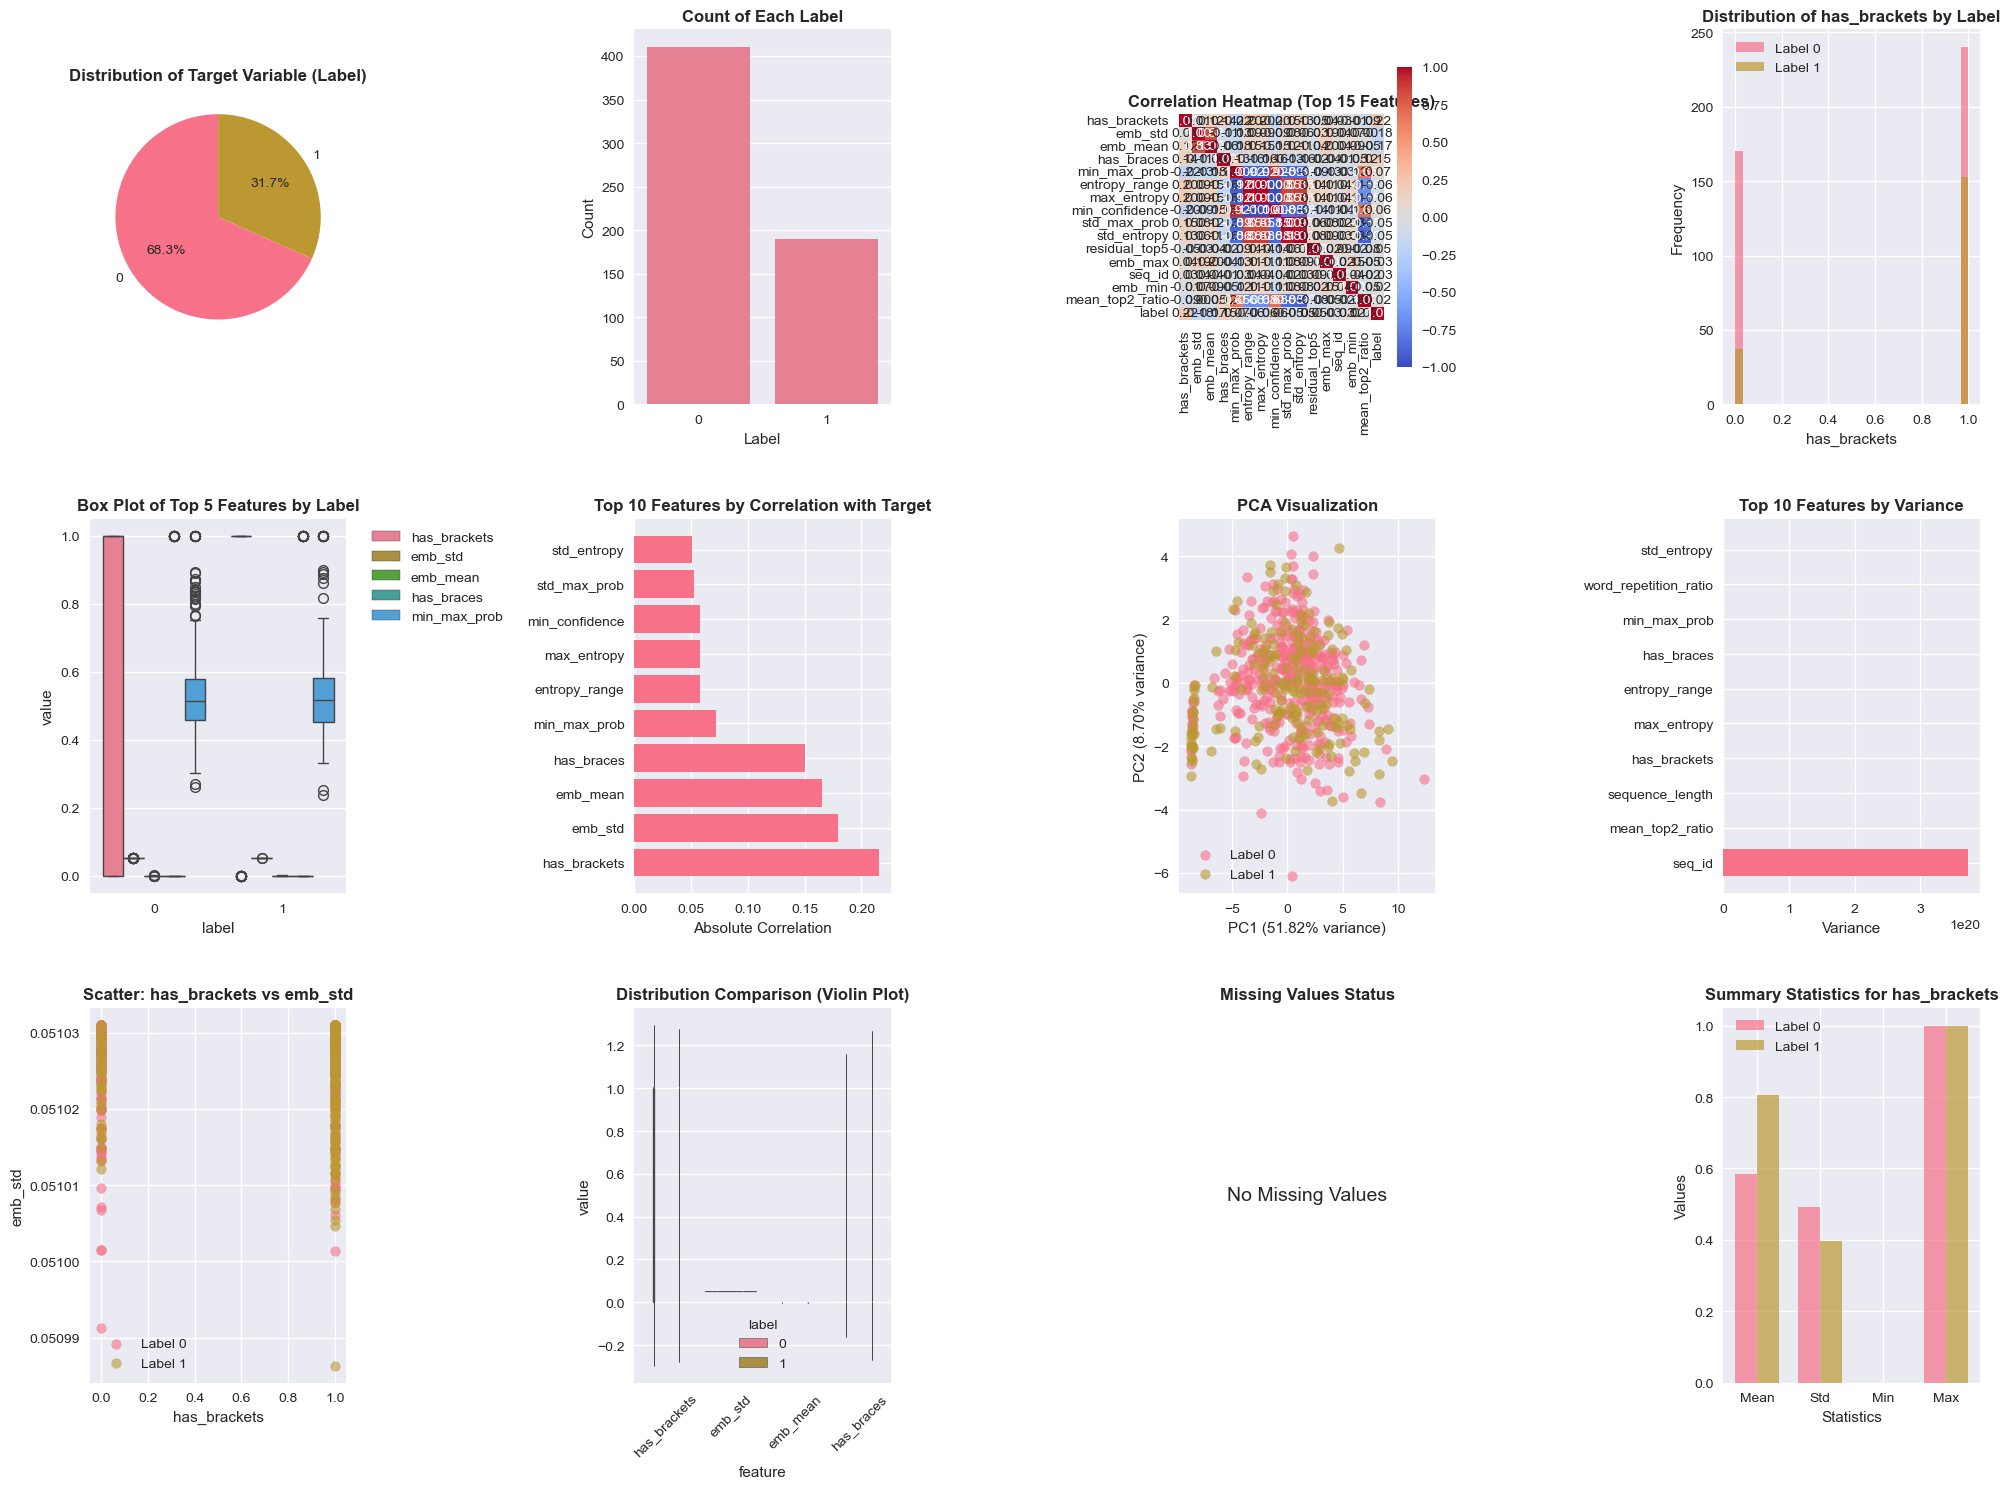


DETAILED ANALYSIS

Target Variable Distribution:
label
0    410
1    190
Name: count, dtype: int64
Class Balance Ratio: 0.463

Top 10 Features Most Correlated with Target:
 1. has_brackets: 0.2152
 2. emb_std: 0.1796
 3. emb_mean: 0.1656
 4. has_braces: 0.1500
 5. min_max_prob: 0.0716
 6. entropy_range: 0.0574
 7. max_entropy: 0.0574
 8. min_confidence: 0.0574
 9. std_max_prob: 0.0525
10. std_entropy: 0.0508

PCA Explained Variance Ratio:
PC1: 0.5182
PC2: 0.0870
Total: 0.6051

Feature Statistics by Label:
------------------------------

has_brackets:
  Label 0: Mean=0.5854, Std=0.4933
  Label 1: Mean=0.8053, Std=0.3970

emb_std:
  Label 0: Mean=0.0510, Std=0.0000
  Label 1: Mean=0.0510, Std=0.0000

emb_mean:
  Label 0: Mean=-0.0004, Std=0.0005
  Label 1: Mean=-0.0006, Std=0.0006

has_braces:
  Label 0: Mean=0.0780, Std=0.2686
  Label 1: Mean=0.1789, Std=0.3843

min_max_prob:
  Label 0: Mean=0.5463, Std=0.1460
  Label 1: Mean=0.5711, Std=0.1898

VISUALIZATION COMPLETE!


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load your data
# Replace 'your_file.csv' with the actual path to your data file
df = pd.read_csv('C:\\Users\\s\\Desktop\\Dev\\SamsungProject\\best_test\\extract_data\\enhanced_router_dataset_emb4.csv')

# Basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum().sum())

# Create a comprehensive visualization
fig = plt.figure(figsize=(20, 15))

# 1. Target variable distribution
plt.subplot(3, 4, 1)
label_counts = df['label'].value_counts()
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Target Variable (Label)', fontsize=12, fontweight='bold')

# 2. Target variable bar plot
plt.subplot(3, 4, 2)
sns.countplot(data=df, x='label')
plt.title('Count of Each Label', fontsize=12, fontweight='bold')
plt.xlabel('Label')
plt.ylabel('Count')

# Get numerical columns (excluding the label)
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'label' in numerical_cols:
    numerical_cols.remove('label')

# 3. Correlation heatmap of top features
plt.subplot(3, 4, 3)
# Select top 15 most correlated features with target
correlations = df[numerical_cols].corrwith(df['label']).abs().sort_values(ascending=False)
top_features = correlations.head(15).index.tolist()
corr_matrix = df[top_features + ['label']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, cbar_kws={'shrink': 0.8})
plt.title('Correlation Heatmap (Top 15 Features)', fontsize=12, fontweight='bold')

# 4. Distribution of top correlated feature by label
plt.subplot(3, 4, 4)
top_feature = correlations.index[0]
for label in df['label'].unique():
    data = df[df['label'] == label][top_feature]
    plt.hist(data, alpha=0.7, label=f'Label {label}', bins=30)
plt.title(f'Distribution of {top_feature} by Label', fontsize=12, fontweight='bold')
plt.xlabel(top_feature)
plt.ylabel('Frequency')
plt.legend()

# 5. Box plot of top features by label
plt.subplot(3, 4, 5)
top_5_features = correlations.head(5).index.tolist()
df_melted = df[top_5_features + ['label']].melt(id_vars=['label'], var_name='feature', value_name='value')
sns.boxplot(data=df_melted, x='label', y='value', hue='feature')
plt.title('Box Plot of Top 5 Features by Label', fontsize=12, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 6. Feature importance visualization (correlation with target)
plt.subplot(3, 4, 6)
top_10_corr = correlations.head(10)
plt.barh(range(len(top_10_corr)), top_10_corr.values)
plt.yticks(range(len(top_10_corr)), top_10_corr.index)
plt.title('Top 10 Features by Correlation with Target', fontsize=12, fontweight='bold')
plt.xlabel('Absolute Correlation')

# 7. PCA visualization
plt.subplot(3, 4, 7)
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numerical_cols])

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create PCA dataframe
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['label'] = df['label'].values

# Plot PCA
for label in df['label'].unique():
    mask = pca_df['label'] == label
    plt.scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'], 
               alpha=0.6, label=f'Label {label}')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA Visualization', fontsize=12, fontweight='bold')
plt.legend()

# 8. Feature variance
plt.subplot(3, 4, 8)
feature_vars = df[numerical_cols].var().sort_values(ascending=False).head(10)
plt.barh(range(len(feature_vars)), feature_vars.values)
plt.yticks(range(len(feature_vars)), feature_vars.index)
plt.title('Top 10 Features by Variance', fontsize=12, fontweight='bold')
plt.xlabel('Variance')

# 9. Scatter plot of top 2 correlated features
plt.subplot(3, 4, 9)
if len(top_features) >= 2:
    for label in df['label'].unique():
        mask = df['label'] == label
        plt.scatter(df.loc[mask, top_features[0]], df.loc[mask, top_features[1]], 
                   alpha=0.6, label=f'Label {label}')
    plt.xlabel(top_features[0])
    plt.ylabel(top_features[1])
    plt.title(f'Scatter: {top_features[0]} vs {top_features[1]}', fontsize=12, fontweight='bold')
    plt.legend()

# 10. Distribution comparison of multiple features
plt.subplot(3, 4, 10)
# Select 4 top features for violin plot
violin_features = top_features[:4]
df_violin = df[violin_features + ['label']].melt(id_vars=['label'], var_name='feature', value_name='value')
sns.violinplot(data=df_violin, x='feature', y='value', hue='label')
plt.title('Distribution Comparison (Violin Plot)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)

# 11. Missing values heatmap (if any)
plt.subplot(3, 4, 11)
if df.isnull().sum().sum() > 0:
    sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
    plt.title('Missing Values Heatmap', fontsize=12, fontweight='bold')
else:
    plt.text(0.5, 0.5, 'No Missing Values', ha='center', va='center', fontsize=14)
    plt.title('Missing Values Status', fontsize=12, fontweight='bold')
    plt.axis('off')

# 12. Summary statistics comparison
plt.subplot(3, 4, 12)
summary_stats = []
for label in df['label'].unique():
    stats = df[df['label'] == label][top_features[0]].describe()
    summary_stats.append([stats['mean'], stats['std'], stats['min'], stats['max']])

summary_df = pd.DataFrame(summary_stats, 
                         columns=['Mean', 'Std', 'Min', 'Max'],
                         index=[f'Label {label}' for label in df['label'].unique()])

x = np.arange(len(summary_df.columns))
width = 0.35

for i, label in enumerate(summary_df.index):
    plt.bar(x + i*width, summary_df.loc[label], width, label=label, alpha=0.7)

plt.xlabel('Statistics')
plt.ylabel('Values')
plt.title(f'Summary Statistics for {top_features[0]}', fontsize=12, fontweight='bold')
plt.xticks(x + width/2, summary_df.columns)
plt.legend()

plt.tight_layout()
plt.show()

# Additional analysis
print("\n" + "="*50)
print("DETAILED ANALYSIS")
print("="*50)

print(f"\nTarget Variable Distribution:")
print(df['label'].value_counts())
print(f"Class Balance Ratio: {df['label'].value_counts().min() / df['label'].value_counts().max():.3f}")

print(f"\nTop 10 Features Most Correlated with Target:")
for i, (feature, corr) in enumerate(correlations.head(10).items(), 1):
    print(f"{i:2d}. {feature}: {corr:.4f}")

print(f"\nPCA Explained Variance Ratio:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.4f}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.4f}")
print(f"Total: {sum(pca.explained_variance_ratio_):.4f}")

# Feature statistics by label
print(f"\nFeature Statistics by Label:")
print("-" * 30)
for feature in top_features[:5]:
    print(f"\n{feature}:")
    for label in df['label'].unique():
        data = df[df['label'] == label][feature]
        print(f"  Label {label}: Mean={data.mean():.4f}, Std={data.std():.4f}")

print("\n" + "="*50)
print("VISUALIZATION COMPLETE!")
print("="*50)

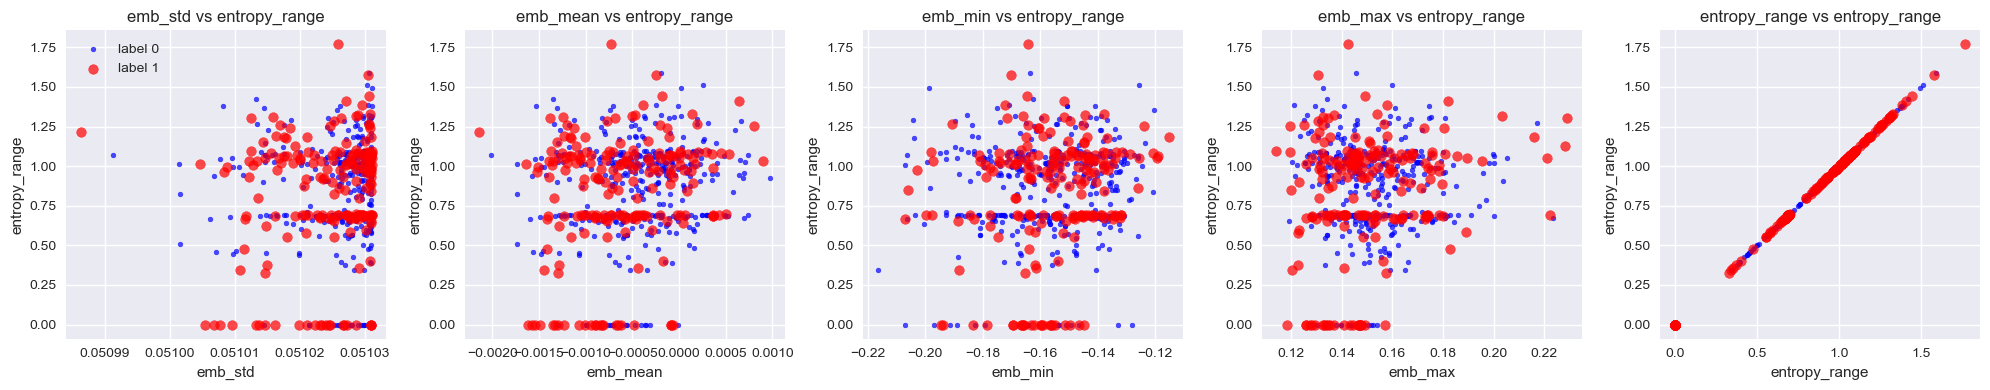

In [6]:
import matplotlib.pyplot as plt

plot_cols = ['emb_std', 'emb_mean', 'emb_min', 'emb_max', 'entropy_range']

plt.figure(figsize=(20, 4))
for i, col in enumerate(plot_cols):
    plt.subplot(1, len(plot_cols), i+1)
    mask0 = df['label'] == 0
    mask1 = df['label'] == 1
    plt.scatter(df.loc[mask0, col], df.loc[mask0, 'entropy_range'], marker='.', color='blue', label='label 0', alpha=0.7)
    plt.scatter(df.loc[mask1, col], df.loc[mask1, 'entropy_range'], marker='o', color='red', label='label 1', alpha=0.7)
    plt.xlabel(col)
    plt.ylabel('entropy_range')
    plt.title(f'{col} vs entropy_range')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

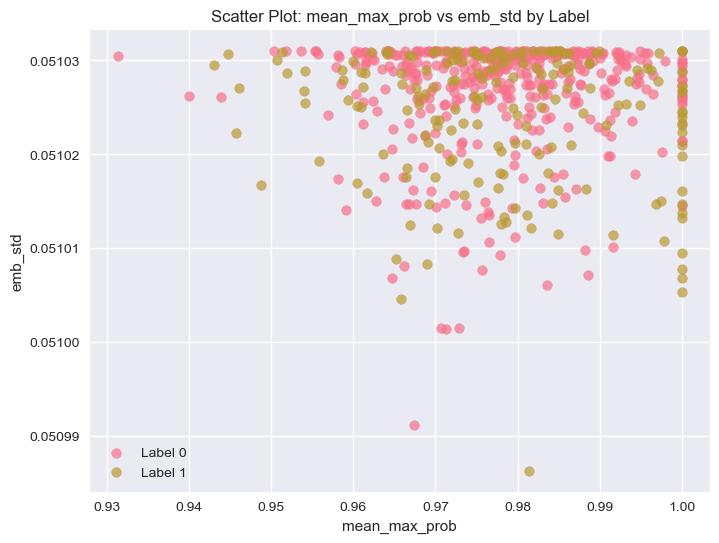

In [7]:
# Based on correlation and feature meaning, let's try 'mean_max_prob' vs 'emb_std'
plt.figure(figsize=(8, 6))
for label in df['label'].unique():
	mask = df['label'] == label
	plt.scatter(df.loc[mask, 'mean_max_prob'], df.loc[mask, 'emb_std'], 
				alpha=0.7, label=f'Label {label}')
plt.xlabel('mean_max_prob')
plt.ylabel('emb_std')
plt.title('Scatter Plot: mean_max_prob vs emb_std by Label')
plt.legend()
plt.show()

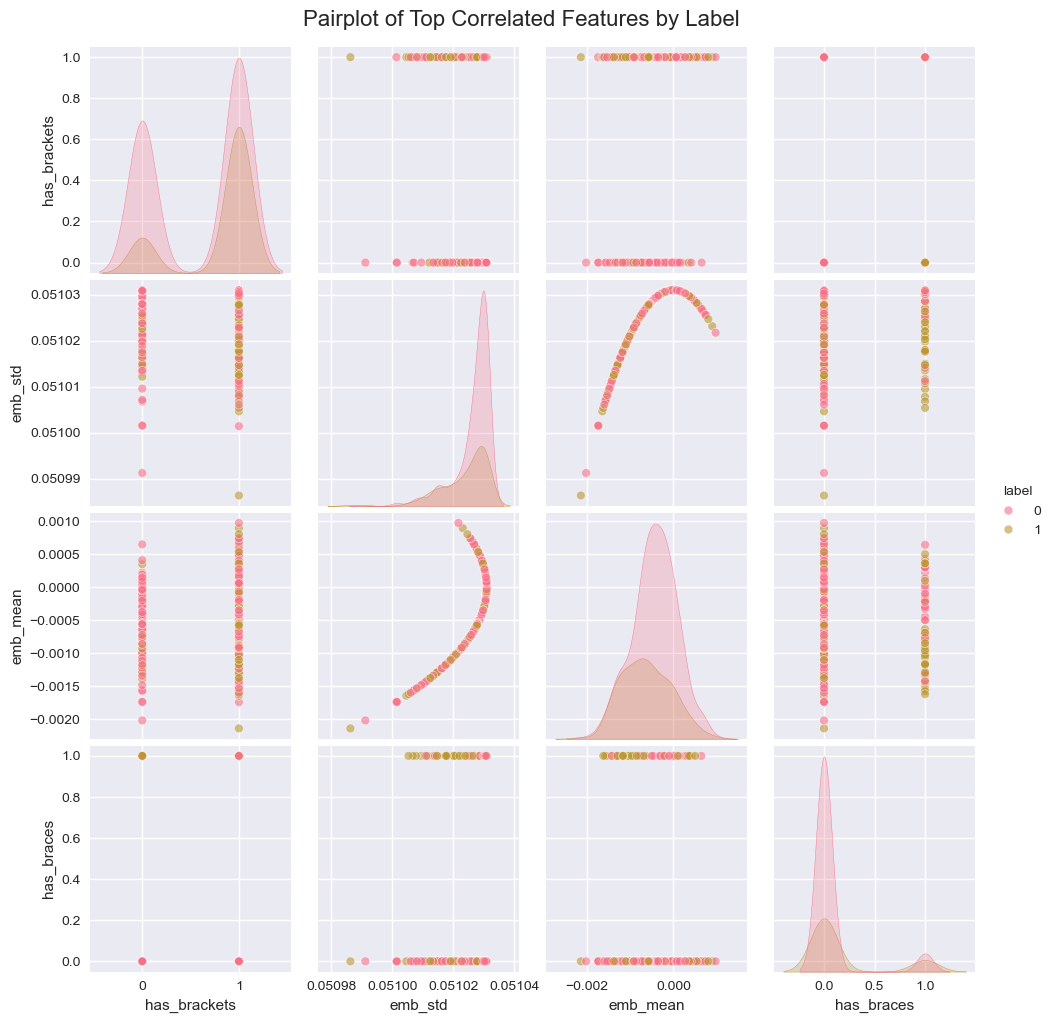

In [8]:
import seaborn as sns

# Try pairplot for top correlated features to see if any pair separates the labels

# Select top 4 most correlated features with label
pairplot_features = top_features[:4] + ['label']
sns.pairplot(df[pairplot_features], hue='label', plot_kws={'alpha':0.6, 's':40})
plt.suptitle("Pairplot of Top Correlated Features by Label", y=1.02, fontsize=16)
plt.show()